In [1]:
from google.colab import drive
drive.mount('/content/drive')

from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt
import time

Mounted at /content/drive


In [2]:
def dct_1d(vector):
    N = len(vector)
    result = np.zeros(N)
    factor = math.pi / (2 * N)
    for k in range(N):
        sum_val = 0.0
        for n in range(N):
            sum_val += vector[n] * math.cos((2*n + 1) * k * factor)
        c = math.sqrt(1.0 / N) if k == 0 else math.sqrt(2.0 / N)
        result[k] = c * sum_val
    return result

def dct_2d(matrix):
    temp = np.array([dct_1d(row) for row in matrix])
    temp = temp.T
    result = np.array([dct_1d(col) for col in temp])
    return result.T

def save_matrix_to_file(matrix, filename):
    with open(filename, 'w') as f:
        for row in matrix:
            f.write(' '.join(map(str, row)) + '\n')


In [15]:
# Шлях до зображення в Google Drive:
#image_path = '/content/drive/MyDrive/РСОІ_Лаб/med.jpg'
image_path = '/content/drive/MyDrive/РСОІ_Лаб/large.jpg'

# Відкриваємо зображення і конвертуємо в градації сірого
img = Image.open(image_path).convert('L')
data = np.array(img, dtype=np.float32)

print("Розмір зображення:", data.shape)

Розмір зображення: (1000, 1000)


In [16]:
# Зберігаємо матрицю у текстовий файл (вхід для паралельної версії)
save_matrix_to_file(data, '/content/drive/MyDrive/РСОІ_Лаб/input_matrix.txt')
print("Матриця збережена у файл input_matrix.txt")

Матриця збережена у файл input_matrix.txt


In [17]:
# Лінійна 2D DCT
start_time = time.time()
result = dct_2d(data)
end_time = time.time()
mins = int((end_time - start_time)/60)

print(f"Час виконання 2D DCT: {mins} хвилин {(end_time - start_time) - mins * 60:.0f} секунд\n")
print(result)

Час виконання 2D DCT: 15 хвилин 29 секунд

[[ 1.71071504e+05 -2.21834279e+03  3.05601938e+04 ... -3.95244278e+00
   1.16864570e+00  2.15617493e+00]
 [ 4.63760863e+03  3.82566786e+01  1.60028223e+03 ...  3.53543652e+00
  -1.51861559e+00 -1.17976120e+00]
 [ 2.53187097e+04  3.96562768e+03  1.03436584e+04 ...  7.96064107e+00
  -1.47876346e-01  3.69579729e-01]
 ...
 [ 2.56655660e+00  1.63880879e+00  4.79549023e+00 ...  1.75716344e+00
  -2.61081091e-01 -2.82266869e+00]
 [-1.78562579e+00 -1.66593566e+00 -2.10047551e+00 ...  6.12167040e-01
   6.81201556e-01 -2.67524325e+00]
 [ 8.45077579e-01 -6.84593222e+00 -4.30890568e+00 ...  9.15271822e-01
   1.18547667e+00 -2.85375934e+00]]


**Зворотній процес**

In [18]:
def idct_1d(vector):
    N = len(vector)
    result = np.zeros(N)
    factor = math.pi / (2 * N)
    for n in range(N):
        sum_val = 0.0
        for k in range(N):
            c = math.sqrt(1.0 / N) if k == 0 else math.sqrt(2.0 / N)
            sum_val += c * vector[k] * math.cos((2*n + 1) * k * factor)
        result[n] = sum_val
    return result

def idct_2d(matrix):
    temp = np.array([idct_1d(row) for row in matrix])
    temp = temp.T
    result = np.array([idct_1d(col) for col in temp])
    return result.T

In [19]:
quant_matrix = np.ones_like(result) * 10

# Квантуємо (ділимо і округлюємо)
quantized = np.round(result / quant_matrix)

# Деквантуємо (відновлюємо)
dequantized = quantized * quant_matrix

# Застосовуємо зворотній DCT
start_time = time.time()
idct_matrix = idct_2d(dequantized)
end_time = time.time()

# Обрізаємо значення в діапазон 0-255 і переводимо у uint8
reconstructed = np.clip(idct_matrix, 0, 255).astype(np.uint8)


**Зображення**

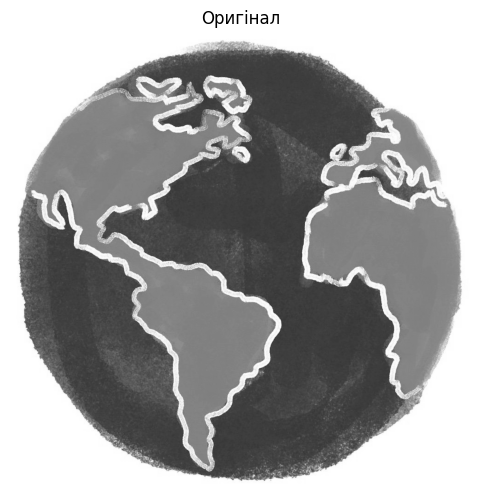

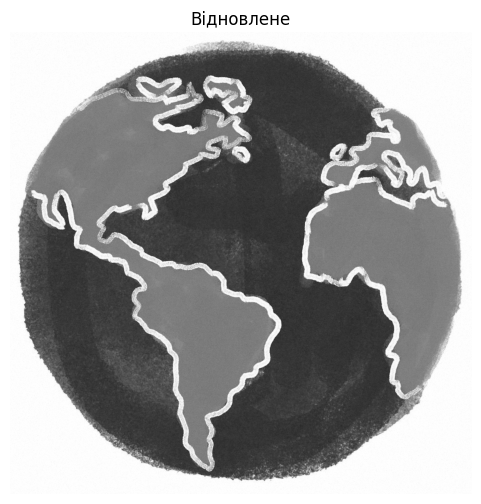

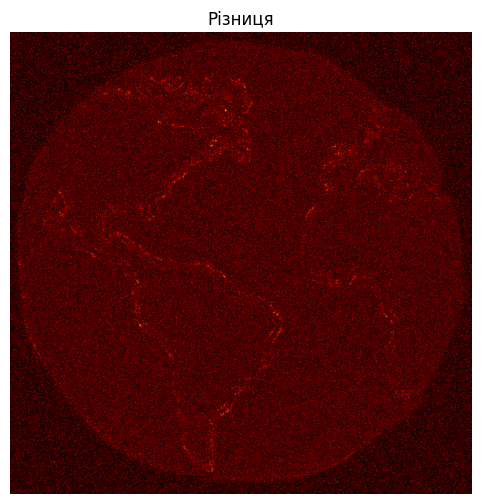

In [20]:
plt.figure(figsize=(6,6))
plt.title('Оригінал')
plt.imshow(data, cmap='gray')
plt.axis('off')
plt.show()

# Відновлене
plt.figure(figsize=(6,6))
plt.title('Відновлене')
plt.imshow(reconstructed, cmap='gray')
plt.axis('off')
plt.show()

# Різниця
plt.figure(figsize=(6,6))
plt.title('Різниця')
plt.imshow(np.abs(data - reconstructed), cmap='hot')
plt.axis('off')
plt.show()

**Порівняння розміру**

In [21]:
import os
reconstructed_img = Image.fromarray(np.clip(reconstructed, 0, 255).astype(np.uint8))
#reconstructed_path = '/content/drive/MyDrive/РСОІ_Лаб/reconstructed_image_med.jpg'
reconstructed_path = '/content/drive/MyDrive/РСОІ_Лаб/reconstructed_image_large.jpg'
reconstructed_img.save(reconstructed_path)

# Тепер відкриваємо файл (для демонстрації) або просто вимірюємо його розмір
reconstructed_size = os.path.getsize(reconstructed_path)
print(f"Розмір реконструйованого зображення: {reconstructed_size / 1024:.2f} KB")

Розмір реконструйованого зображення: 92.84 KB


In [22]:
original_path = image_path
original_size = os.path.getsize(original_path)
print(f"Розмір оригінального зображення: {original_size / 1024:.2f} KB")

Розмір оригінального зображення: 115.91 KB


**Відновлення по частотах отриманих під час паралельної обробки**

In [13]:
result = np.loadtxt('/content/drive/MyDrive/РСОІ_Лаб/output.txt')

quant_matrix = np.ones_like(result) * 10

# Квантуємо (ділимо і округлюємо)
quantized = np.round(result / quant_matrix)

# Деквантуємо (відновлюємо)
dequantized = quantized * quant_matrix

# Застосовуємо зворотній DCT
start_time = time.time()
idct_matrix = idct_2d(dequantized)
end_time = time.time()

# Обрізаємо значення в діапазон 0-255 і переводимо у uint8
reconstructed = np.clip(idct_matrix, 0, 255).astype(np.uint8)

**Візуалізація**

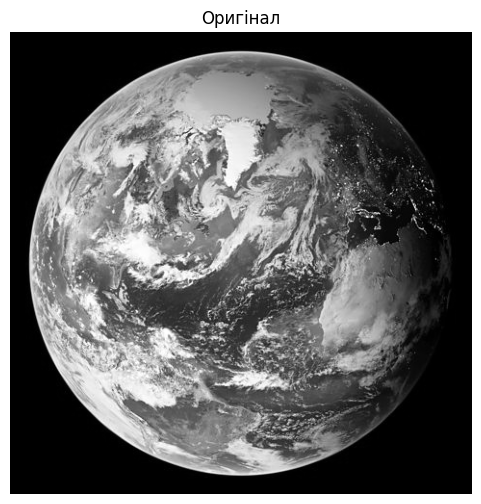

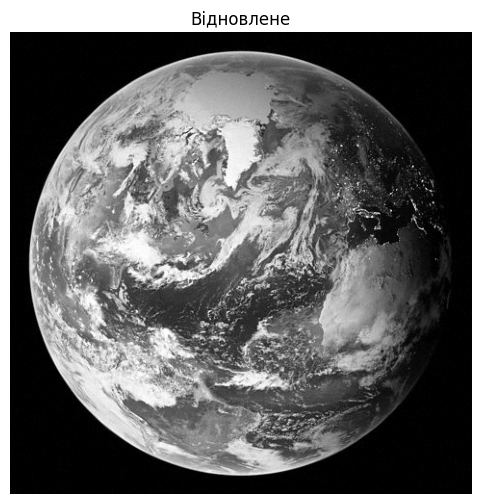

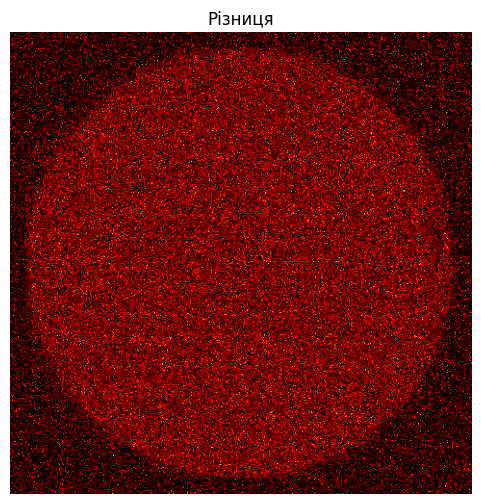

In [14]:
plt.figure(figsize=(6,6))
plt.title('Оригінал')
plt.imshow(data, cmap='gray')
plt.axis('off')
plt.show()

# Відновлене
plt.figure(figsize=(6,6))
plt.title('Відновлене')
plt.imshow(reconstructed, cmap='gray')
plt.axis('off')
plt.show()

# Різниця
plt.figure(figsize=(6,6))
plt.title('Різниця')
plt.imshow(np.abs(data - reconstructed), cmap='hot')
plt.axis('off')
plt.show()